## In-memory lens correction processing using em-stitch

First download and unzip example data.  This example uses:
21617_R1_166_T5_15_20201231140731_20201231140731

This is an autoTEM montage collected with highly overlapping images.

As part of the acquisition, the autoTEM produces point correspondences by template matching
and writes these correspondences to a json file.


In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import copy
import json

import numpy
import pathlib
import scipy.sparse

# renderapi is on pypi as render-python.  Models and interfaces with Render for alignment metadata
import renderapi

# bigfeta alignment solver has utilites for file reading
import bigfeta.utils

import em_stitch.lens_correction.mesh_and_solve_transform

In [3]:
# location of example data that has metadata files including tiles and lens corrections data
lc_dir = "/data/21617_R1_166_T5_15_20201231140731_20201231140731"
lc_dir_path = pathlib.Path(lc_dir)

In [4]:
# load tile metadata as render-python objects
tilespecs_bn = "raw_tilespecs.json.gz"
tilespecs_path = lc_dir_path / tilespecs_bn

input_tilespecs_json = bigfeta.utils.jsongz.load(str(tilespecs_path))
input_tilespecs = [
    renderapi.tilespec.TileSpec(
        json=input_ts_d)
    for input_ts_d in input_tilespecs_json
]

# ResolvedTiles objects are a common entrypoint for manipulations
lc_rts = renderapi.resolvedtiles.ResolvedTiles(
    tilespecs=input_tilespecs,
    transformList=[]
)

In [5]:
# read point correspondences
# these are in the Render pointmatch format -- defined in local coordinates of both "p" and "q" tiles.

lc_correspondences_bn = "collection.json.gz"
lc_correspondences_path = lc_dir_path / lc_correspondences_bn

lc_input_correspondences = bigfeta.utils.jsongz.load(str(lc_correspondences_path))

### Calculate Lens Correction

In [6]:
# define input parameters for solving

nvertex = 1000

# regularization parameters for components
regularization_dict = {
    "translation_factor": 0.001,
    "default_lambda": 1.0,
    "lens_lambda": 1.0
}

# thresholds defining an acceptable solution.
#   solves exceeding these will raise an exception in em_stitch.lens_correction.mesh_and_solve_transform._solve_resolvedtiles
good_solve_dict = {
    "error_mean": 0.2,
    "error_std": 2.0,
    "scale_dev": 0.1
}

solve_resolvedtiles_args = (
    lc_rts, lc_input_correspondences,
    nvertex, regularization_dict["default_lambda"],
    regularization_dict["translation_factor"],
    regularization_dict["lens_lambda"],
    good_solve_dict
)

In [7]:
solved_rts, lc_tform, jresult = em_stitch.lens_correction.mesh_and_solve_transform._solve_resolvedtiles(*solve_resolvedtiles_args)

/opt/conda/lib/python3.7/site-packages/render_python-2.2.3.dev4+g368c416-py3.7.egg/renderapi/transform/leaf/affine_models.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [8]:
# show residual information dictionary
print(json.dumps(jresult, indent=2))

{
  "x_res_min": -4.622,
  "x_res_max": 30.48,
  "x_res_mean": 0.015,
  "x_res_std": 0.813,
  "y_res_min": -41.163,
  "y_res_max": 15.058,
  "y_res_mean": -0.015,
  "y_res_std": 0.825
}


In [9]:
# helper functions for displaying lens correction as a quiver plot
def determine_numX_numY_rectangle(width, height, meshcellsize=32):
    """determine number of x and y points in a 2d rectangular mesh
    """
    numX = max([2, numpy.around(width/meshcellsize)])
    numY = max([2, numpy.around(height/meshcellsize)])
    return int(numX), int(numY)


def generate_square_mesh_pts(width, height, meshcellsize=64):
    """generate vertices representing a square mesh defined by the
    width and height of a rectanglular area
    """
    numX, numY = determine_numX_numY_rectangle(width, height, meshcellsize)
    return numpy.mgrid[0:width-1:numX*1j, 0:height-1:numY*1j].reshape(2, -1).T


def vec_to_rgb(angle, absolute, max_abs=0):
    """represent vector in a scaled rgb color space
    """
    angle = angle % (2 * numpy.pi)
    if angle < 0:
        angle += 2 * numpy.pi
    return matplotlib.colors.hsv_to_rgb((
        angle / 2 / numpy.pi,
        absolute / max_abs,
        absolute / max_abs
    ))

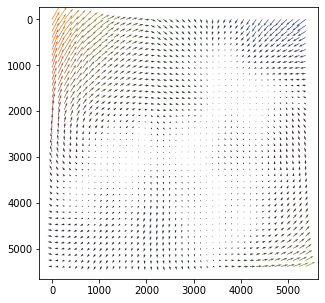

In [10]:
# generate representative mesh and transformed mesh
h = solved_rts.tilespecs[0].height
w = solved_rts.tilespecs[0].width
sqmesh = generate_square_mesh_pts(w, h, meshcellsize=128)
tformed_sqmesh = lc_tform.apply(sqmesh)

# calculate displacement vectors and represent as rgb
pts_diff = tformed_sqmesh - sqmesh

veclen = numpy.linalg.norm(pts_diff, axis=1)
angle = numpy.arctan2(pts_diff[:, 0], pts_diff[:, 1])

rgb_vals = numpy.array([
    vec_to_rgb(ang, l, veclen.max())
    for ang, l in zip(
        angle.flatten(), veclen.flatten())])

# plot quiver representation
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.quiver(sqmesh[:, 0], sqmesh[:, 1], pts_diff[:, 0], pts_diff[:, 1], color=rgb_vals)
ax.invert_yaxis()

below, we have a more detailed step-by-step process that could be used to explore different parameters or better understand the methods

In [14]:
# generate source triangulation based on match distribution
lc_mesh = em_stitch.lens_correction.mesh_and_solve_transform._create_mesh(lc_rts, lc_input_correspondences, nvertex, bruteforce_simplex_counts=False)

In [15]:
# build arrays used by solver
A, weights, b, lens_dof_start = em_stitch.lens_correction.mesh_and_solve_transform.create_A(lc_input_correspondences, lc_rts.tilespecs, lc_mesh)
x0 = em_stitch.lens_correction.mesh_and_solve_transform.create_x0(A.shape[1], lc_rts.tilespecs)
reg = em_stitch.lens_correction.mesh_and_solve_transform.create_regularization(
    A.shape[1], len(lc_rts.tilespecs),
    regularization_dict["default_lambda"],
    regularization_dict["translation_factor"],
    regularization_dict["lens_lambda"]
)

In [16]:
# solve
solution, errx, erry = em_stitch.lens_correction.mesh_and_solve_transform.solve(
        A, weights, reg, x0, b)

In [17]:
# describe solution array as transforms
transforms = em_stitch.lens_correction.mesh_and_solve_transform.create_transforms(len(lc_rts.tilespecs), solution)

# use adaptive mesh estimation to refine the resultant mesh and transform
#   This can be expensive
lc_tform = em_stitch.lens_correction.mesh_and_solve_transform.create_thinplatespline_tf(lc_mesh, solution, lens_dof_start)

# applt this to the input tilespecs
solved_rts = renderapi.resolvedtiles.ResolvedTiles(
        tilespecs=em_stitch.lens_correction.mesh_and_solve_transform.new_specs_with_tf(
            lc_tform,
            lc_rts.tilespecs,
            transforms
        ),
        transformList=[lc_tform]
    )

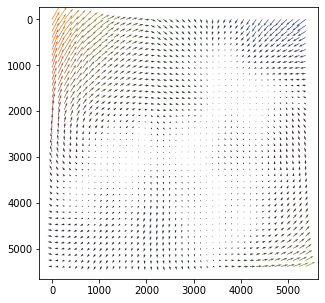

In [18]:
# generate representative mesh and transformed mesh
h = solved_rts.tilespecs[0].height
w = solved_rts.tilespecs[0].width
sqmesh = generate_square_mesh_pts(w, h, meshcellsize=128)
tformed_sqmesh = lc_tform.apply(sqmesh)

pts_diff = tformed_sqmesh - sqmesh

veclen = numpy.linalg.norm(pts_diff, axis=1)
angle = numpy.arctan2(pts_diff[:, 0], pts_diff[:, 1])

rgb_vals = numpy.array([
    vec_to_rgb(ang, l, veclen.max())
    for ang, l in zip(
        angle.flatten(), veclen.flatten())])

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.quiver(sqmesh[:, 0], sqmesh[:, 1], pts_diff[:, 0], pts_diff[:, 1], color=rgb_vals)
ax.invert_yaxis()

### Next Steps:
 - write to render service using renderapi.resolvedtiles.put_tilespecs
 - view (using e.g. neuroglancer) or materialize
 - apply this transform to corresponding montage tiles before deriving point correspondences